In [6]:
# можно снести уж
!pip install tensorflow-model-optimization
!pip install tensorflow-datasets

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 #тут датасет
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot

# модель нашей свёрточной сети
model = tf.keras.models.Sequential([
    # блок 1 (32 фильтра)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # блок 2 (64 фильтра)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # блок 3 (128 фильтров)
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # блок 4 (256 фильтров)
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # распределение данных по массивам
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

ModuleNotFoundError: No module named 'tf_keras'

In [ ]:
# загрузка датасета cifar10, тренировочные, валидационные и тестовые данные
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    with_info=True,
)

# нормализация входящего изображения
# то же самое, что и делали в 3 лабе (деление на 255 и приведение к float32)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.image.convert_image_dtype(image, tf.float32), label

# загрузка данных пакетами по 128 картинок
batch_size = 128

# подготовка датасета
def prepare_dataset(ds, buffer_size=None):
  # autotune -- самостоятельный подбор потоков
  ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()
  if buffer_size:
    ds = ds.shuffle(buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds


# подготовка тренировочного, валидационного и тестового датасетов соотв
ds_train = prepare_dataset(ds_train,
                           buffer_size=ds_info.splits['train'].num_examples)
# тренировочные данные мы перетряхиваем, чтобы модель не учила порядок данных
# поэтому берём размер в виде самого буфера (чтобы первые 100 условно не перемешались)
ds_val = prepare_dataset(ds_val)
ds_test = prepare_dataset(ds_test)

In [ ]:
# компиляция и обучение
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

model.fit(
  ds_train,
  epochs=10,
  validation_data=ds_val)

# оценка модели
_, dense_model_accuracy = model.evaluate(ds_test, verbose=0)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.3635 - loss: 2.1688 - val_accuracy: 0.1994 - val_loss: 3.2189
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5838 - loss: 1.2329 - val_accuracy: 0.6558 - val_loss: 0.9878
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6754 - loss: 0.9664 - val_accuracy: 0.7092 - val_loss: 0.8546
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7330 - loss: 0.7744 - val_accuracy: 0.7506 - val_loss: 0.7034
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7697 - loss: 0.6588 - val_accuracy: 0.7170 - val_loss: 0.7968
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7971 - loss: 0.5775 - val_accuracy: 0.7648 - val_loss: 0.6864
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8109 - loss: 0.5377 - val_accuracy: 0.7764 - val_loss: 0.6701
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8368 - loss: 0.4728 - val_accuracy: 0.77

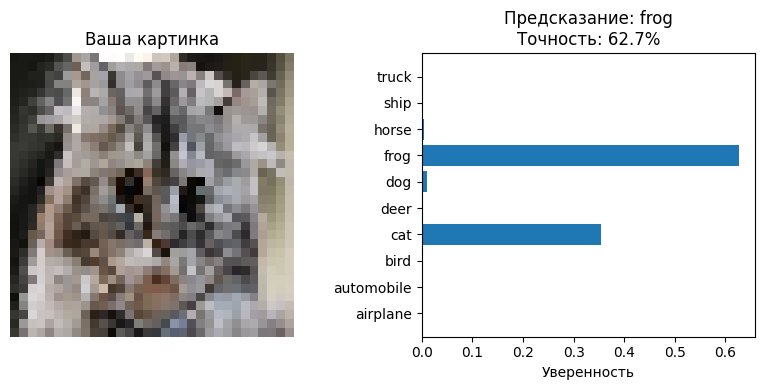

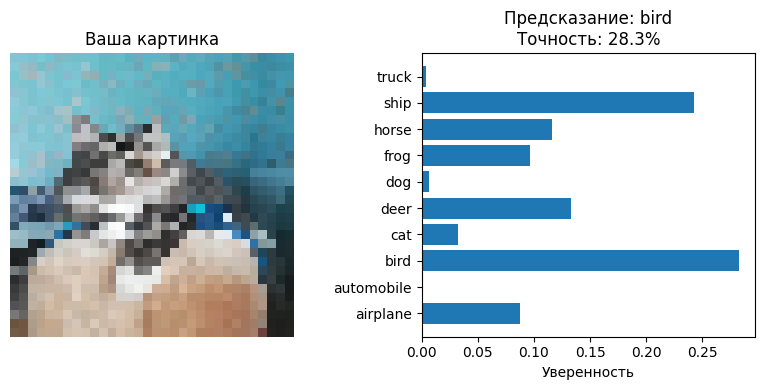

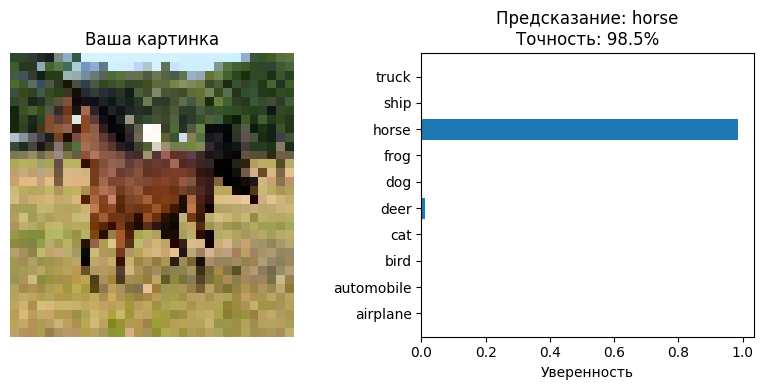

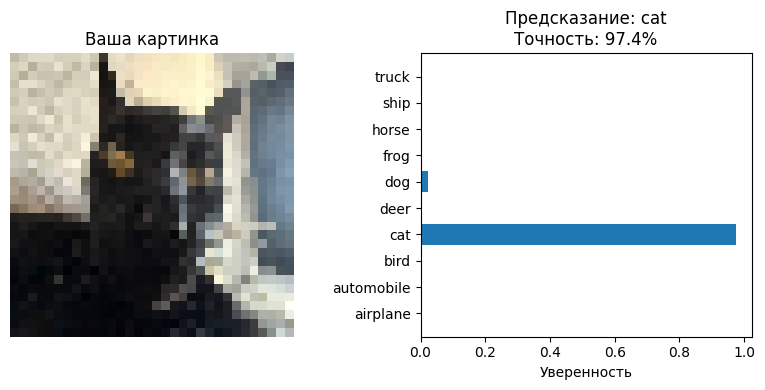

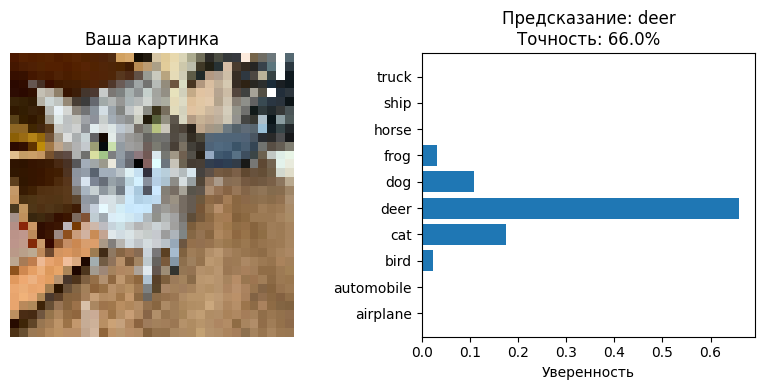

In [ ]:
from tensorflow.keras.preprocessing import image


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def predict_my_image(image_path):

    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #возврат массива из 10 эл-ов с предположениями а что на картинке, ну вот те штуки [0.01, 0.25 ..]
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    num_max = np.max(prediction)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Ваша картинка')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    classes = range(10)
    plt.barh(classes, prediction[0])
    plt.yticks(classes, class_names)
    plt.xlabel('Уверенность')
    plt.title(f'Предсказание: {class_names[predicted_class]}\nТочность: {num_max:.1%}')

    plt.tight_layout()
    plt.show()


predict_my_image('cat.jpg')
predict_my_image('margo.jpg')
predict_my_image('hor.jpg')
predict_my_image('sh.jpg')
predict_my_image('ko.jpg')

In [ ]:
list_of_weights = model.get_weights()

list_of_updated_weights = []

for layer in list_of_weights:
    shape = layer.shape # сохраняем форму слоя, чтобы потом вернуть её обратно
    flat_layer = layer.flatten() # разворачиваем веса в 1D, чтобы удобно пройтись по каждому

    # проходим по каждому весу
    # если |weight| < 0,15 — обнуляем, иначе оставляем как есть
    # т.е. это вот тот самый тупой прунинг, который откидывает фигню
    updated_layer = np.array([0 if abs(weight) < 0.15 else weight
                              for weight in flat_layer])

    updated_layer = updated_layer.reshape(shape)
    list_of_updated_weights.append(updated_layer)

In [ ]:
new_model = tf.keras.models.clone_model(model)
new_model.set_weights(list_of_updated_weights)

# проверка точности на этой новой модели
new_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

_, model_accuracy = new_model.evaluate(ds_test, verbose=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0989 - loss: 2.3044


In [ ]:
# дообучение модели и проверка на данных
new_model.fit(
  ds_train,
  epochs=3,
  validation_data=ds_val)

_, model_accuracy = new_model.evaluate(ds_test, verbose=0)

Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.4145 - loss: 1.5718 - val_accuracy: 0.5418 - val_loss: 1.4382
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6631 - loss: 0.9430 - val_accuracy: 0.6970 - val_loss: 0.8775
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7354 - loss: 0.7556 - val_accuracy: 0.7326 - val_loss: 0.7976


In [ ]:
import tensorflow as tf

# класс дистилляции прям из примера. потом допишу если что.
# играться можно как тут так и ниже (но ниже приоритет очев, т.к. тут дефолт)
# как по мне лучше всего альфа 0.3 температура 5 и 8 эпох
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3,
        temperature=5,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

In [ ]:
import tensorflow as tf

# student = прунинговая модель
student = new_model
# teacher = большая модель до прунинга
teacher = model

distiller = Distiller(student=student, teacher=teacher)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.3,
    temperature=5,
)

distiller.fit(
    ds_train,
    epochs=8,
    validation_data=ds_val
)

distiller.evaluate(ds_test)

Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - loss: 0.0396 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.8120
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.8108
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.2736 - val_sparse_categorical_accuracy: 0.8092
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.2695 - val_sparse_categorical_accuracy: 0.8062
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.2557 - val_sparse_categorical_accuracy: 0.7984
Epoch 6/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.2993 - val_sparse_categorical_accuracy: 0.821

[0.3057660460472107, 0.8047999739646912]